In [13]:
%matplotlib inline
from netCDF4 import Dataset as nc, num2date
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from matplotlib import cm
import os
import sys
import pytz
from datetime import datetime, timedelta
from cross_sect import getCrossSection, haversine
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

### Define the input netCDF data
First define the experiment setup to construct the input files. The Experiment setup contains the following info:
 * domwain_name = Where took the experiment place
 * exp_id       = What is the parametrization setup
 * init_time    = The time of initialisation
 
Then define all the input-fields, where they are stored and the variable names
Also define the Experiment-setup to 

In [2]:
datadir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
domain_name = 'darwin'
exp_id = 'RA1T'
modeldir = []
init = ('20061110T0000Z', '20061110T1200Z', '20061117T0000Z', '20061117T1200Z')
for init_time in init:
        modeldir.append(os.path.join(datadir, domain_name, exp_id, init_time))
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC

Now get all files model input and observations

In [3]:
cpolF = os.path.join(datadir,'CPOL_2p5km_2006111000-2006111823.nc')
umf = {}
for t in ('surf', 'w', 'precip'):
    umf[t] = []
    for i, path in enumerate(modeldir):
        tmp = os.path.join(path,'UM_0p44km_%s_%s.nc'%(t,init[i]))
        if os.path.isfile(tmp):
            umf[t].append(tmp)

### Read the data with xarray define the smalest common area and get the common time-steps

In [4]:
cpol = xr.open_dataset(cpolF)
um_p00 = xr.open_dataset(umf['precip'][0])
um_p12 = xr.open_dataset(umf['precip'][1])

Round the times to the next 10 min

In [5]:
for f, tvar, fname in ((um_p00, 't', umf['precip'][0]), (um_p12, 't', umf['precip'][1]), (cpol, 'time', cpolF)):
    with nc(fname) as ncf:
        try:
            T=pd.DatetimeIndex(num2date(ncf.variables['time'][:],ncf.variables['time'].units)).round('10min')
        except KeyError:
            T=pd.DatetimeIndex(num2date(ncf.variables['t'][:],ncf.variables['t'].units)).round('10min')
        f[tvar] = T

In [ ]:
um_p00.close()
um_p00.close()
cpol.close()

In [6]:
lons, lats, times = [], [], []
for dataset, lonn, latn, timen in ((cpol, 'longitude', 'latitude', 'time'),
                                  (um_p00, 'longitude', 'latitude', 't'),
                                  (um_p12, 'longitude', 'latitude', 't')):
    lon, lat, time = dataset[lonn].values, dataset[latn].values, dataset[timen].values
    lons.append((lon.min(), lon.max()))
    lats.append((lat.min(), lat.max()))
    times.append((time.min(), time.max()))
lons, lats, times = np.array(lons), np.array(lats), np.array(times, dtype='datetime64[m]')
domain_ko = dict(minlon=lons[:,0].max(), maxlon=lons[:,1].min(), maxlat=lats[:,1].min(), minlat=lats[:,0].max())
times = pd.date_range(times[:,0].max(), times[:,1].min(), freq='10 min').round('10min')

In [7]:
times

DatetimeIndex(['2006-11-10 12:00:00', '2006-11-10 12:10:00',
               '2006-11-10 12:20:00', '2006-11-10 12:30:00',
               '2006-11-10 12:40:00', '2006-11-10 12:50:00',
               '2006-11-10 13:00:00', '2006-11-10 13:10:00',
               '2006-11-10 13:20:00', '2006-11-10 13:30:00',
               ...
               '2006-11-18 16:20:00', '2006-11-18 16:30:00',
               '2006-11-18 16:40:00', '2006-11-18 16:50:00',
               '2006-11-18 17:00:00', '2006-11-18 17:10:00',
               '2006-11-18 17:20:00', '2006-11-18 17:30:00',
               '2006-11-18 17:40:00', '2006-11-18 17:50:00'],
              dtype='datetime64[ns]', length=1188, freq=None)

### Define Tiwi-Islands

In [8]:
tiwilons = (130.024,131.58)
tiwilats = (-11.99,-11.083)

lons1_s, lons1_e = np.argmin(np.fabs(cpol['longitude'][0]-tiwilons[0])).values, np.argmin(np.fabs(cpol['longitude'][0]-tiwilons[1])).values
lons2_s, lons2_e = np.argmin(np.fabs(um_p00['longitude'][:]-tiwilons[0])).values, np.argmin(np.fabs(um_p00['longitude'][:]-tiwilons[1])).values
lons3_s, lons3_e = np.argmin(np.fabs(um_p12['longitude'][:]-tiwilons[0])).values, np.argmin(np.fabs(um_p12['longitude'][:]-tiwilons[1])).values

lats1_s, lats1_e = np.argmin(np.fabs(cpol['latitude'][:,0]-tiwilats[0])).values, np.argmin(np.fabs(cpol['latitude'][:,0]-tiwilats[1])).values
lats2_s, lats2_e = np.argmin(np.fabs(um_p00['latitude'][:]-tiwilats[0])).values, np.argmin(np.fabs(um_p00['latitude'][:]-tiwilats[1])).values
lats3_s, lats3_e = np.argmin(np.fabs(um_p12['latitude'][:]-tiwilats[0])).values, np.argmin(np.fabs(um_p12['latitude'][:]-tiwilats[1])).values


DF = {'CPOL':np.nanmean(cpol['radar_estimated_rain_rate'].loc[times[0]:times[-1]].values[:,lats1_s:lats1_e+1,lons1_s:lons1_e+1], axis=(1,2)),
      'UM 00UTC':(um_p00['field1681'].loc[times[0]:times[-1]].values[:,lats2_s:lats2_e+1,lons2_s:lons2_e+1]*100).mean(axis=(1,2)),
      'UM 12UTC':(um_p12['field1681'].loc[times[0]:times[-1]].values[:,lats2_s:lats2_e+1,lons2_s:lons2_e+1]*100).mean(axis=(1,2))}

#DF = {'CPOL':np.nanmean(cpol['radar_estimated_rain_rate'].loc[times[0]:times[-1]].values[:,lats1_s:lats1_e+1,lons1_s:lons1_e+1], axis=(1,2)),
#     'UM 00UTC':um_p00['precip'].loc[times[0]:times[-1]].values[:,lats2_s:lats2_e+1,lons2_s:lons2_e+1].mean(axis=(1,2)),
#      'UM 12UTC':um_p12['precip'].loc[times[0]:times[-1]].values[:,lats2_s:lats2_e+1,lons2_s:lons2_e+1].mean(axis=(1,2))}


In [ ]:
print((DF['UM 12UTC']).max())
print((DF['UM 00UTC']).max())
print((DF['CPOL']).max())

### Define the corss section

In [9]:
start_point = dict(lon=129.995, lat=-11.2285)
end_point = dict(lon=131.339, lat=-11.818)
with nc(os.path.join(datadir,'UM_0p44km_orog.nc')) as g:
    H = g['ht'][0,0,:]
idx = getCrossSection((start_point['lon'], start_point['lat']),
                      (end_point['lon'], end_point['lat']), um_p00['longitude'], um_p00['latitude'], 0.905)
sec = H[idx]
dist = haversine(start_point['lon'], end_point['lon'], start_point['lat'], end_point['lat'])
mpl.rcParams['contour.negative_linestyle'] = 'dashed'

 Creating Comparison-2006-11-10_2130.png ....    

/usr/lib/python3/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


 Creating Comparison-2006-11-19_0320.png .... ok 


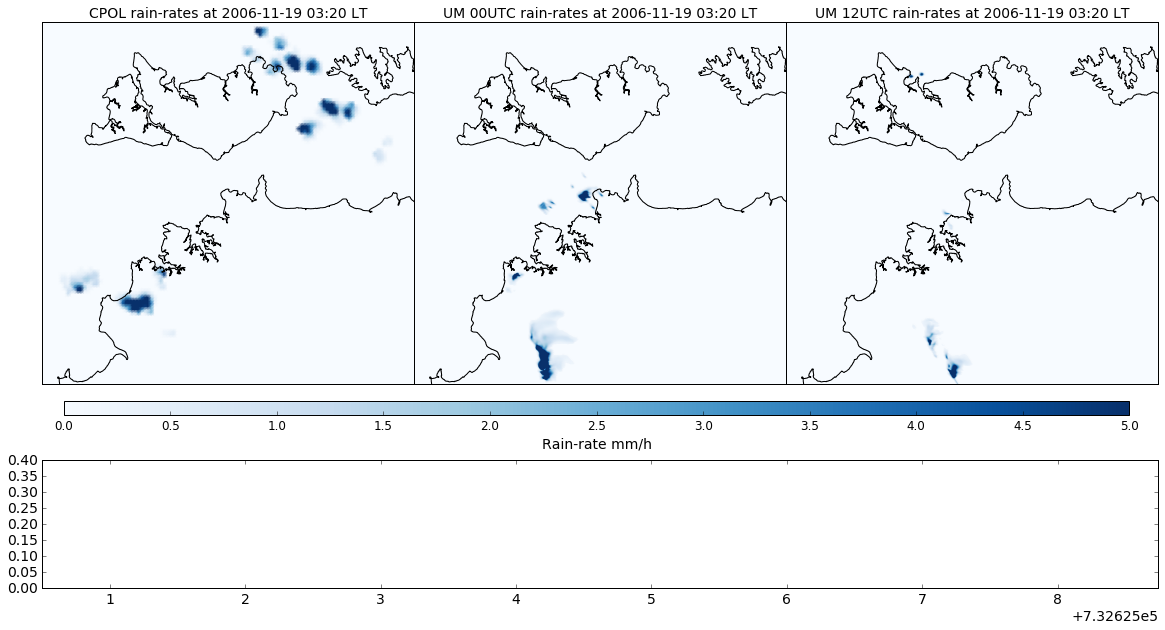

In [19]:
tt = pd.Timestamp('2006-11-12 04:40')
nn = np.argmin(np.abs(times - tt))
first = True
nn = 0
ii = nn
T = times[:].tz_localize(utc).tz_convert(timezone).to_pydatetime()
cmap = cm.Blues
plotdir=os.path.join(datadir,'Plot','Week_of_Hector')
fig = plt.figure(figsize=(20,10), dpi=72)
for t in times[nn:]:
#def plot_map(frame):
    #t = times[frame]
    now = t.tz_localize(utc).tz_convert(timezone)
    tit1 = 'CPOL rain-rates at %s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    tit2 = 'UM 00UTC rain-rates at %s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    tit3 = 'UM 12UTC rain-rates at %s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    

    data1 = np.ma.masked_less(cpol['radar_estimated_rain_rate'].loc[t],0.2).filled(0)
    data2 = np.ma.masked_less(um_p00['field1681'].loc[t]*100,0.2).filled(0)
    data3 = np.ma.masked_less(um_p12['field1681'].loc[t]*100,0.2).filled(0)
    
    fname = os.path.join(plotdir,'Comparison-%s.png'%(now.strftime('%Y-%m-%d_%H%M')))
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s ....    '%os.path.basename(fname))
    sys.stdout.flush()
    if first:
        gs = gridspec.GridSpec(5, 3, height_ratios=[4, 1])
                       #width_ratios=[1, 1],
                       #height_ratios=[1, 1]
                       #)
        ax1 = plt.subplot2grid((5, 3), (0, 0), rowspan=4)
        ax2 = plt.subplot2grid((5, 3), (0, 1), rowspan=4)
        ax3 = plt.subplot2grid((5, 3), (0, 2), rowspan=4)
        ax4 = plt.subplot2grid((5, 3), (-1, 0), colspan=3)
        #ax5 = plt.subplot(gs[-1,1])
        #ax6 = plt.subplot(gs[-1,2])
        
        m1 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax1)
        m2 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax2)
        m3 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax3)
        im1 = m1.pcolormesh(cpol['longitude'], cpol['latitude'], data1, vmin=0.0, vmax=5., cmap=cmap,
                              shading='gouraud')
        im2 = m2.pcolormesh(um_p00['longitude'], um_p12['latitude'], data2, vmin=0.0, vmax=5., cmap=cmap,
                              shading='gouraud')
        im3 = m3.pcolormesh(um_p12['longitude'], um_p00['latitude'], data3, vmin=0.0, vmax=5., cmap=cmap,
                              shading='gouraud')

        ax4.plot(T[nn:ii], DF['CPOL'][nn:ii], 'r-', label='CPOL')
        ax4.plot(T[nn:ii], DF['UM 00UTC'][nn:ii]*100, 'b-', label='UM 00UTC')
        ax4.plot(T[nn:ii], DF['UM 12UTC'][nn:ii]*100, 'b--', label='UM 12UTC')
        ax4.plot(T[nn:], DF['CPOL'][ii:], 'k-', alpha=0.2)
        ax4.plot(T[nn:], DF['UM 00UTC'][ii:], 'k-', alpha=0.2)
        ax4.plot(T[nn:], DF['UM 12UTC'][ii:], 'k--', alpha=0.2)
        
        ax4.plot(T[ii], DF['CPOL'][ii], marker='o',color='r', alpha=0.8)
        ax4.plot(T[ii], DF['UM 00UTC'][ii]*100, marker='1', color='b', alpha=0.8)
        ax4.plot(T[ii], DF['UM 12UTC'][ii]*100, marker='2', color='b', alpha=0.8)
        
        ax4.legend(loc='upper right', prop={'size': 12})
        ax4.set_ylabel('Avg. rain-rate [mm/h]')
        ax4.set_ylim((0,0.4))
        ax4.set_xlabel('Local Time')
        
        #cs1 = ax5.contour(X, Y, w1,  colors='k')
        #cs2 = ax6.contour(X, Y, w2,  colors='k')
        
        
        
        m1.drawcoastlines()
        m2.drawcoastlines()
        m3.drawcoastlines()
        
        fig.subplots_adjust(bottom=0.01, hspace=0.0, wspace=0.0)
        #gs.update(bottom=0.01,wspace=0.0, hspace=0.0)
        cbar_ax = fig.add_axes([0.14, 0.25, 0.74, 0.02])
        cbar=fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Rain-rate mm/h',size=14)
        
        cbar.ax.tick_params(labelsize=12)
        first = False
    else:
        ax4.clear()
        ax4.plot(T[nn:ii], DF['CPOL'][nn:ii], 'r-', label='CPOL')
        ax4.plot(T[nn:ii], DF['UM 00UTC'][nn:ii], 'b-', label='UM 00UTC')
        ax4.plot(T[nn:ii], DF['UM 12UTC'][nn:ii], 'b--', label='UM 12UTC')
        ax4.plot(T[nn:], DF['CPOL'][nn:], 'k-', alpha=0.2)
        ax4.plot(T[nn:], DF['UM 00UTC'][nn:], 'k-', alpha=0.2)
        ax4.plot(T[nn:], DF['UM 12UTC'][nn:], 'k--', alpha=0.2)
        
        ax4.plot(T[ii], DF['CPOL'][ii], marker='o',color='r', alpha=0.8)
        ax4.plot(T[ii], DF['UM 00UTC'][ii], marker='1', color='b', alpha=0.8)
        ax4.plot(T[ii], DF['UM 12UTC'][ii], marker='2', color='b', alpha=0.8)
        ax4.legend(loc='upper right', prop={'size': 12})
        ax4.set_ylabel('Avg. rain-rate [mm/h]')
        ax4.set_ylim((0,0.4))
        ax4.set_xlabel('Local Time')
        for im, data in ((im1, data1), (im2, data2), (im3, data3)):
            im.set_array(data.ravel())
    ax1.set_title(tit1,size=14)
    ax2.set_title(tit2,size=14)
    ax3.set_title(tit3,size=14)
    
    fig.savefig(fname, bbox_inches='tight', format='png', dpi=72)
    #break
    ax4.cla()
    ii += 1
    #break
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s .... ok'%os.path.basename(fname))
    sys.stdout.flush()
sys.stdout.write('\n')

### Create the map

In [ ]:
#precp_anim = FuncAnimation(fig, plot_map, frames=range(nn,len(times)), interval=200)
#cmap.set_bad('k')
#X,Y = np.meshgrid(sec, um044['z'][:20])


### Plot some sea-breeze condtions in the 0p44km Simulation

In [ ]:
cpol = nc(cpolF)
test044 = nc(umtestF)
time = pd.DatetimeIndex(num2date(test044.variables['time'][:],test044.variables['time'].units))
cpol_t = pd.DatetimeIndex(num2date(cpol.variables['time'][:],cpol.variables['time'].units)).tz_localize('UTC').tz_convert(pytz.timezone('Australia/Darwin')).tz_localize(None)


In [ ]:
n1, n2=0, 63
time[n1]
t1 = np.where(cpol_t == time[n1])[0][0]
t2 = np.where(cpol_t == time[n2])[0][0]
cpol_r = cpol['radar_estimated_rain_rate'][t1:t2]


In [ ]:
first = True
ii=1
lat = test044.variables['lat'][:]
lon = test044.variables['lon'][:]
for tt in range(n1, n2+1):
    now = time[tt]
    tit2 = '%s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    tit1 = '%s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    tit3 = '%s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    

    data1 = np.ma.masked_less(test044['precip'][tt],0.2).filled(0)
    
    data2 = test044.variables['temp'][tt]
    u = test044.variables['u-wind'][tt]
    v = test044.variables['v-wind'][tt]
    grad = -1* (np.diff(u)+np.diff(v))
    cpol_rr = np.ma.masked_less(np.ma.masked_invalid(cpol_r[tt]),0.2).filled(0)
    
    
    fname = os.path.join(os.path.dirname(umtestF),'Comparison-%s.png'%(now.strftime('%Y-%m-%d_%H%M')))
    fname = os.path.join(os.path.dirname(umtestF),'UM_Sim-%i.png'%ii)
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s ....    '%os.path.basename(fname))
    sys.stdout.flush()
    if first:
        gs = gridspec.GridSpec(1, 3)
                       #width_ratios=[1, 1],
                       #height_ratios=[1, 1]
                       #)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax3 = plt.subplot(gs[0, 2])
        
        m1 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax1)
        m2 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax2)
        m3 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax3)
        im1 = m1.pcolormesh(cpol['longitude'], cpol['latitude'], cpol_rr, vmin=0.0, vmax=10., cmap='Blues', shading='gouraud')  
        im2 = m2.pcolormesh(lon[:], lat[:], data1, vmin=0.0, vmax=10.,cmap='Blues', shading='gouraud')
        im3 = m3.pcolormesh(lon[:], lat[:], data2, vmin=26, vmax=32, cmap=plt.cm.coolwarm, shading='gouraud')
        #q2 = m2.quiver(lon[::50], lat[::50], u[::50,::50], v[::50,::50], latlon=True)

        
        
        m1.drawcoastlines()
        m2.drawcoastlines()
        m3.drawcoastlines()
        
        fig.subplots_adjust(bottom=0.01, hspace=0.0, wspace=0.0)
        gs.update(bottom=0.0,wspace=0.1, hspace=0.1)
        cbar1=m1.colorbar(im1,location='bottom')
        cbar1.set_label('Radar Estimated Rain-rate mm/h',size=14)
        cbar2=m2.colorbar(im2,location='bottom')
        cbar2.set_label('Modelled Rain-rate mm/h',size=14)
        cbar2.ax.tick_params(labelsize=12)
        cbar3=m3.colorbar(im3,location='bottom')
        cbar3.set_label('Modelled Temperature 1.5m [$^\\circ$C]',size=14)
        cbar3.ax.tick_params(labelsize=12)
        first = False
    else:
        for im, data in ((im1, cpol_rr), (im2, data1), (im3, data2)):
            im.set_array(data.ravel())
    ax1.set_title(tit1,size=14)
    ax2.set_title(tit2,size=14)
    ax3.set_title(tit3,size=14)
    #break
    fig.savefig(fname, bbox_inches='tight', format='png', transparent=True)
    #ax4.cla()
    ii += 1
    #break
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s .... ok'%os.path.basename(fname))
    sys.stdout.flush()
sys.stdout.write('\n')